In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
import pandas as pd
import tikzplotlib

sns.set(context="paper")

In [2]:
trainer_dict = {
    "Distributed": "PyTorch DDP",
    "Horovod": "Horovod",
    "local": "Local Training"
}

In [3]:
def create_measurement_df(file_name):
    with open(file_name) as f:
        results = json.load(f)['results']
    trainer = []
    nodes = []
    batch_size = []
    slots = []
    seconds = []
    memory = []
    
    regex = re.compile(r'0: Memory Usage: (\d+\.\d+), Training Duration: (\d+\.\d+)')

    for result in results:
        config = result['config']
        parsed_regex = regex.search(result['stderr'])
        trainer.append(config['trainer'].capitalize())
        nodes.append(config['hosts'])
        batch_size.append(config['parameters']['--batch-size'])
        slots.append(config["slots"])
        seconds.append(float(parsed_regex.group(2)))
        memory.append(float(parsed_regex.group(1)))
    return pd.DataFrame({"Trainer": trainer, "Nodes": nodes, "Batches": batch_size, "Slots": slots, "Training Time": seconds, "Memory Usage": memory})

In [12]:
df1 = create_measurement_df('results_ranks.json')
df2 = create_measurement_df('results_202007141530.json')
df3 = create_measurement_df('results_202007141730.json')
df0 = pd.concat((df1, df2, df3))
df0["Trainer"] = df0["Trainer"].replace("Distributed", "DDP")

df = df0[df0["Slots"] == 1].drop("Slots", axis=1)

baseline_memory =df[df["Trainer"] == "Local"]["Memory Usage"].mean()
baseline_time =df[df["Trainer"] == "Local"]["Training Time"].mean()
df = df[~(df["Trainer"] == "Local")]

df["Memory Usage Overall"] = df["Memory Usage"] * df["Nodes"]

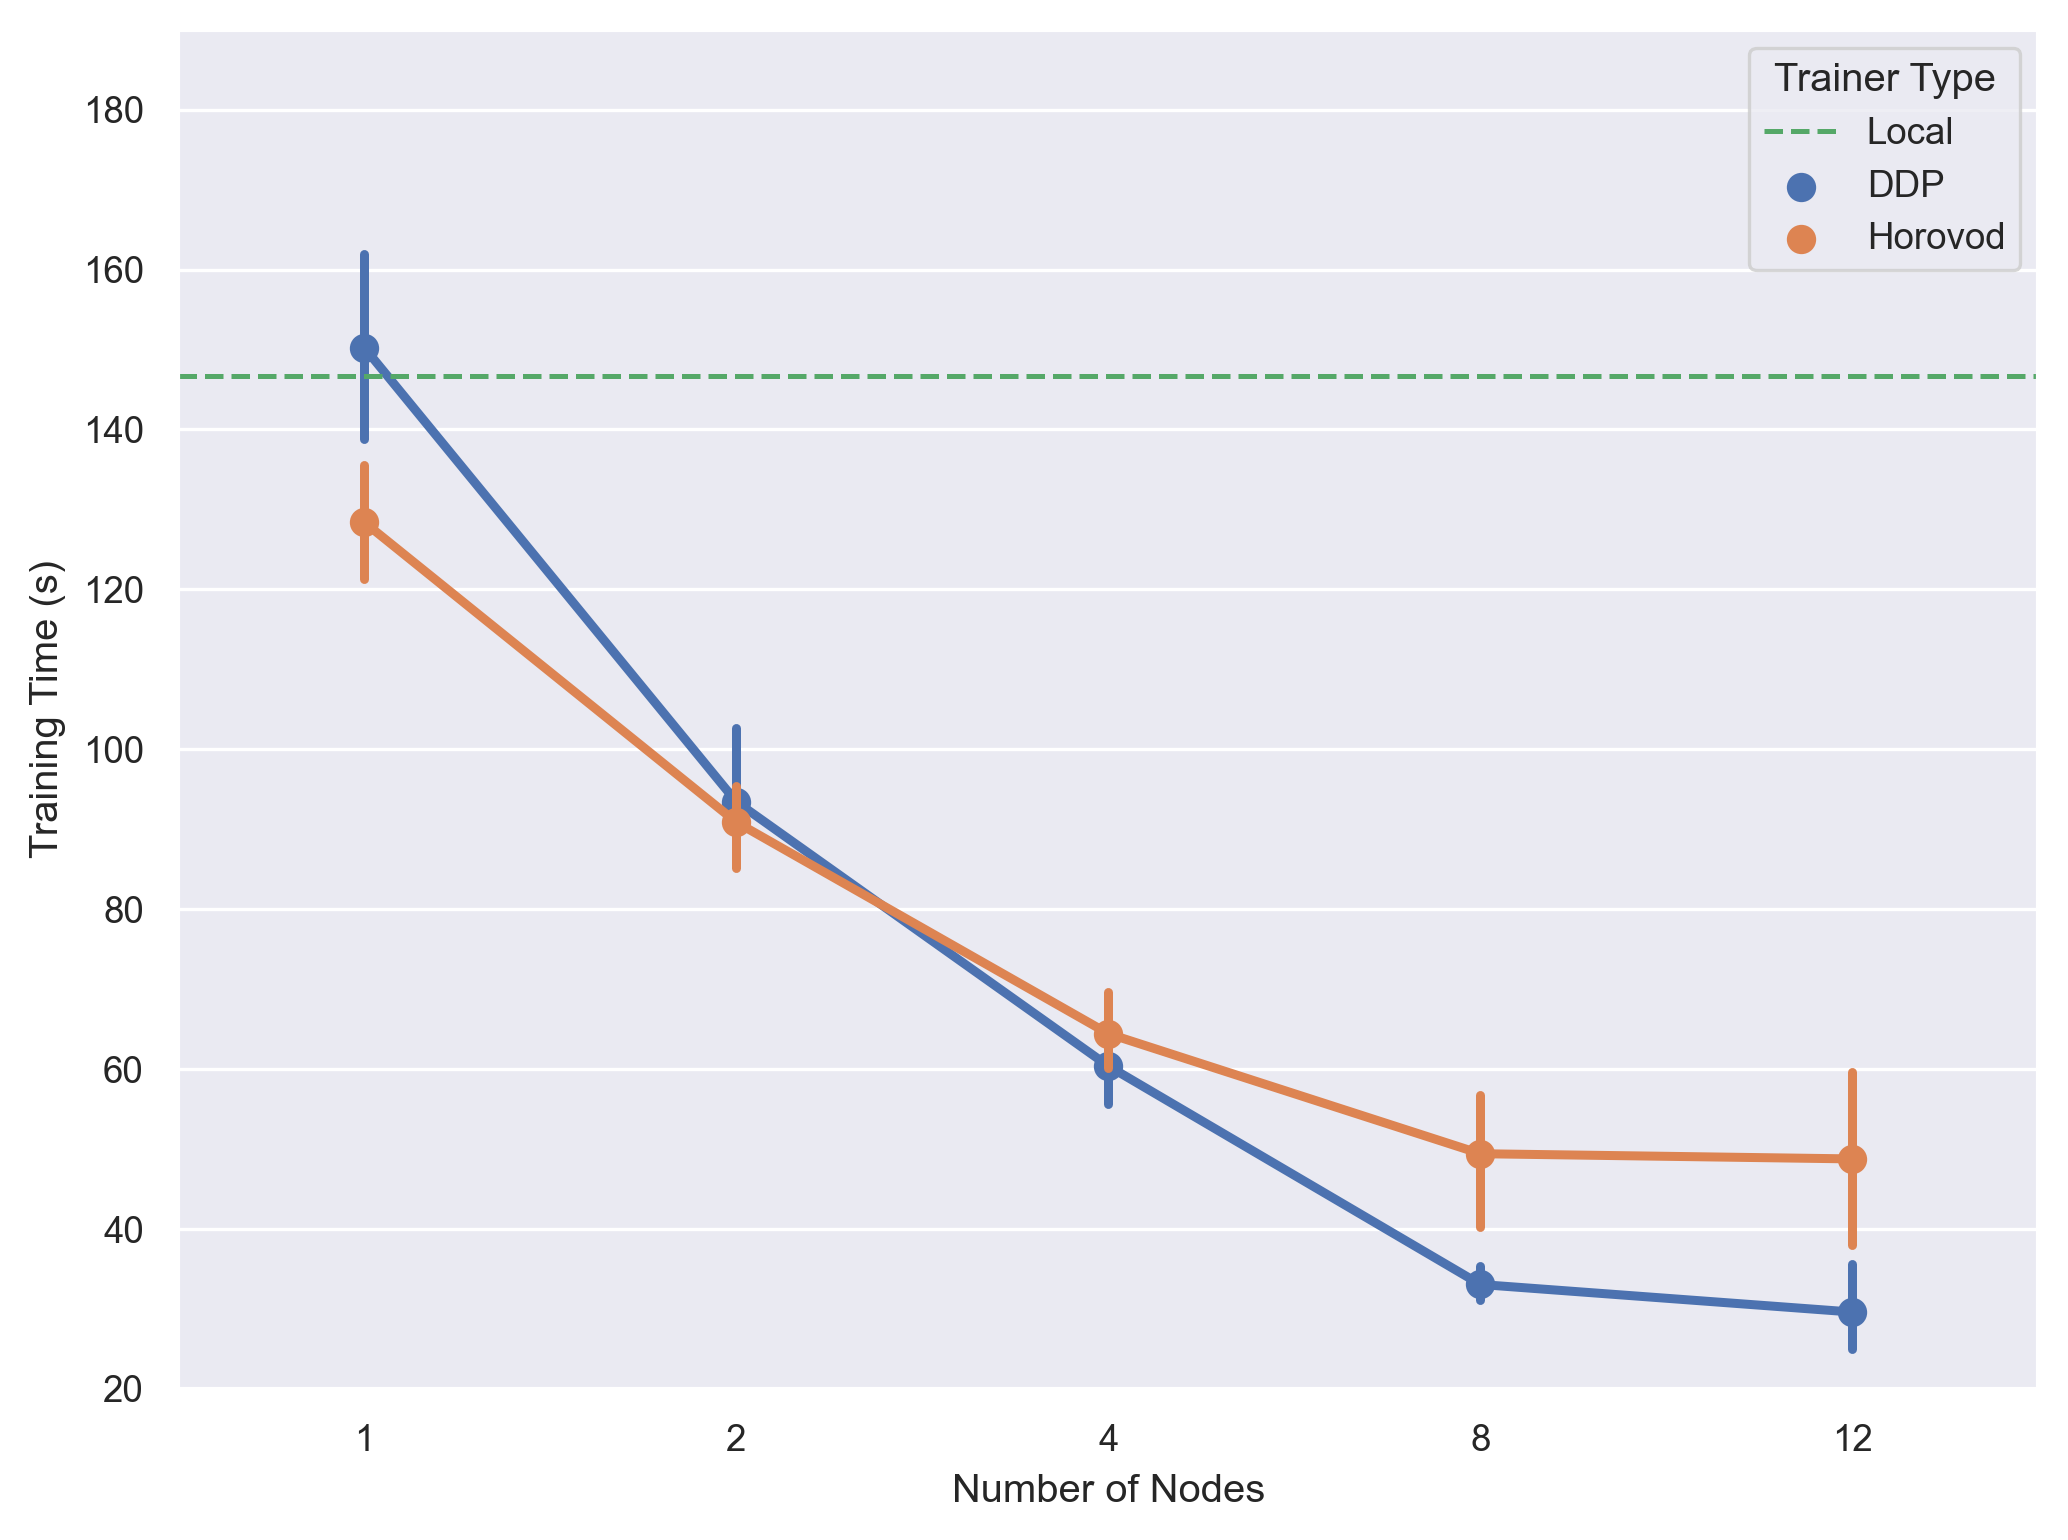

In [14]:
fig = plt.figure(figsize=(8, 6), dpi=300, facecolor="w")
#fig.patch.set_alpha(0.0)
ax = sns.pointplot(x="Nodes", y="Training Time", hue="Trainer", data=df)
ax.axhline(y=baseline_time, color=sns.color_palette()[2], linestyle='--', label="Local")
ax.set_ylim((20, 190))
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Training Time (s)")
ax.legend().set_title("Trainer Type")
#ax.set_title("Training Time per Epoch for Number of Nodes and Trainer Type")
#plt.savefig("training_time_overall.png", dpi=300)
#tikzplotlib.get_tikz_code(figure=fig)
#tikzplotlib.save(f"training_time_overall.tex", figure=fig)

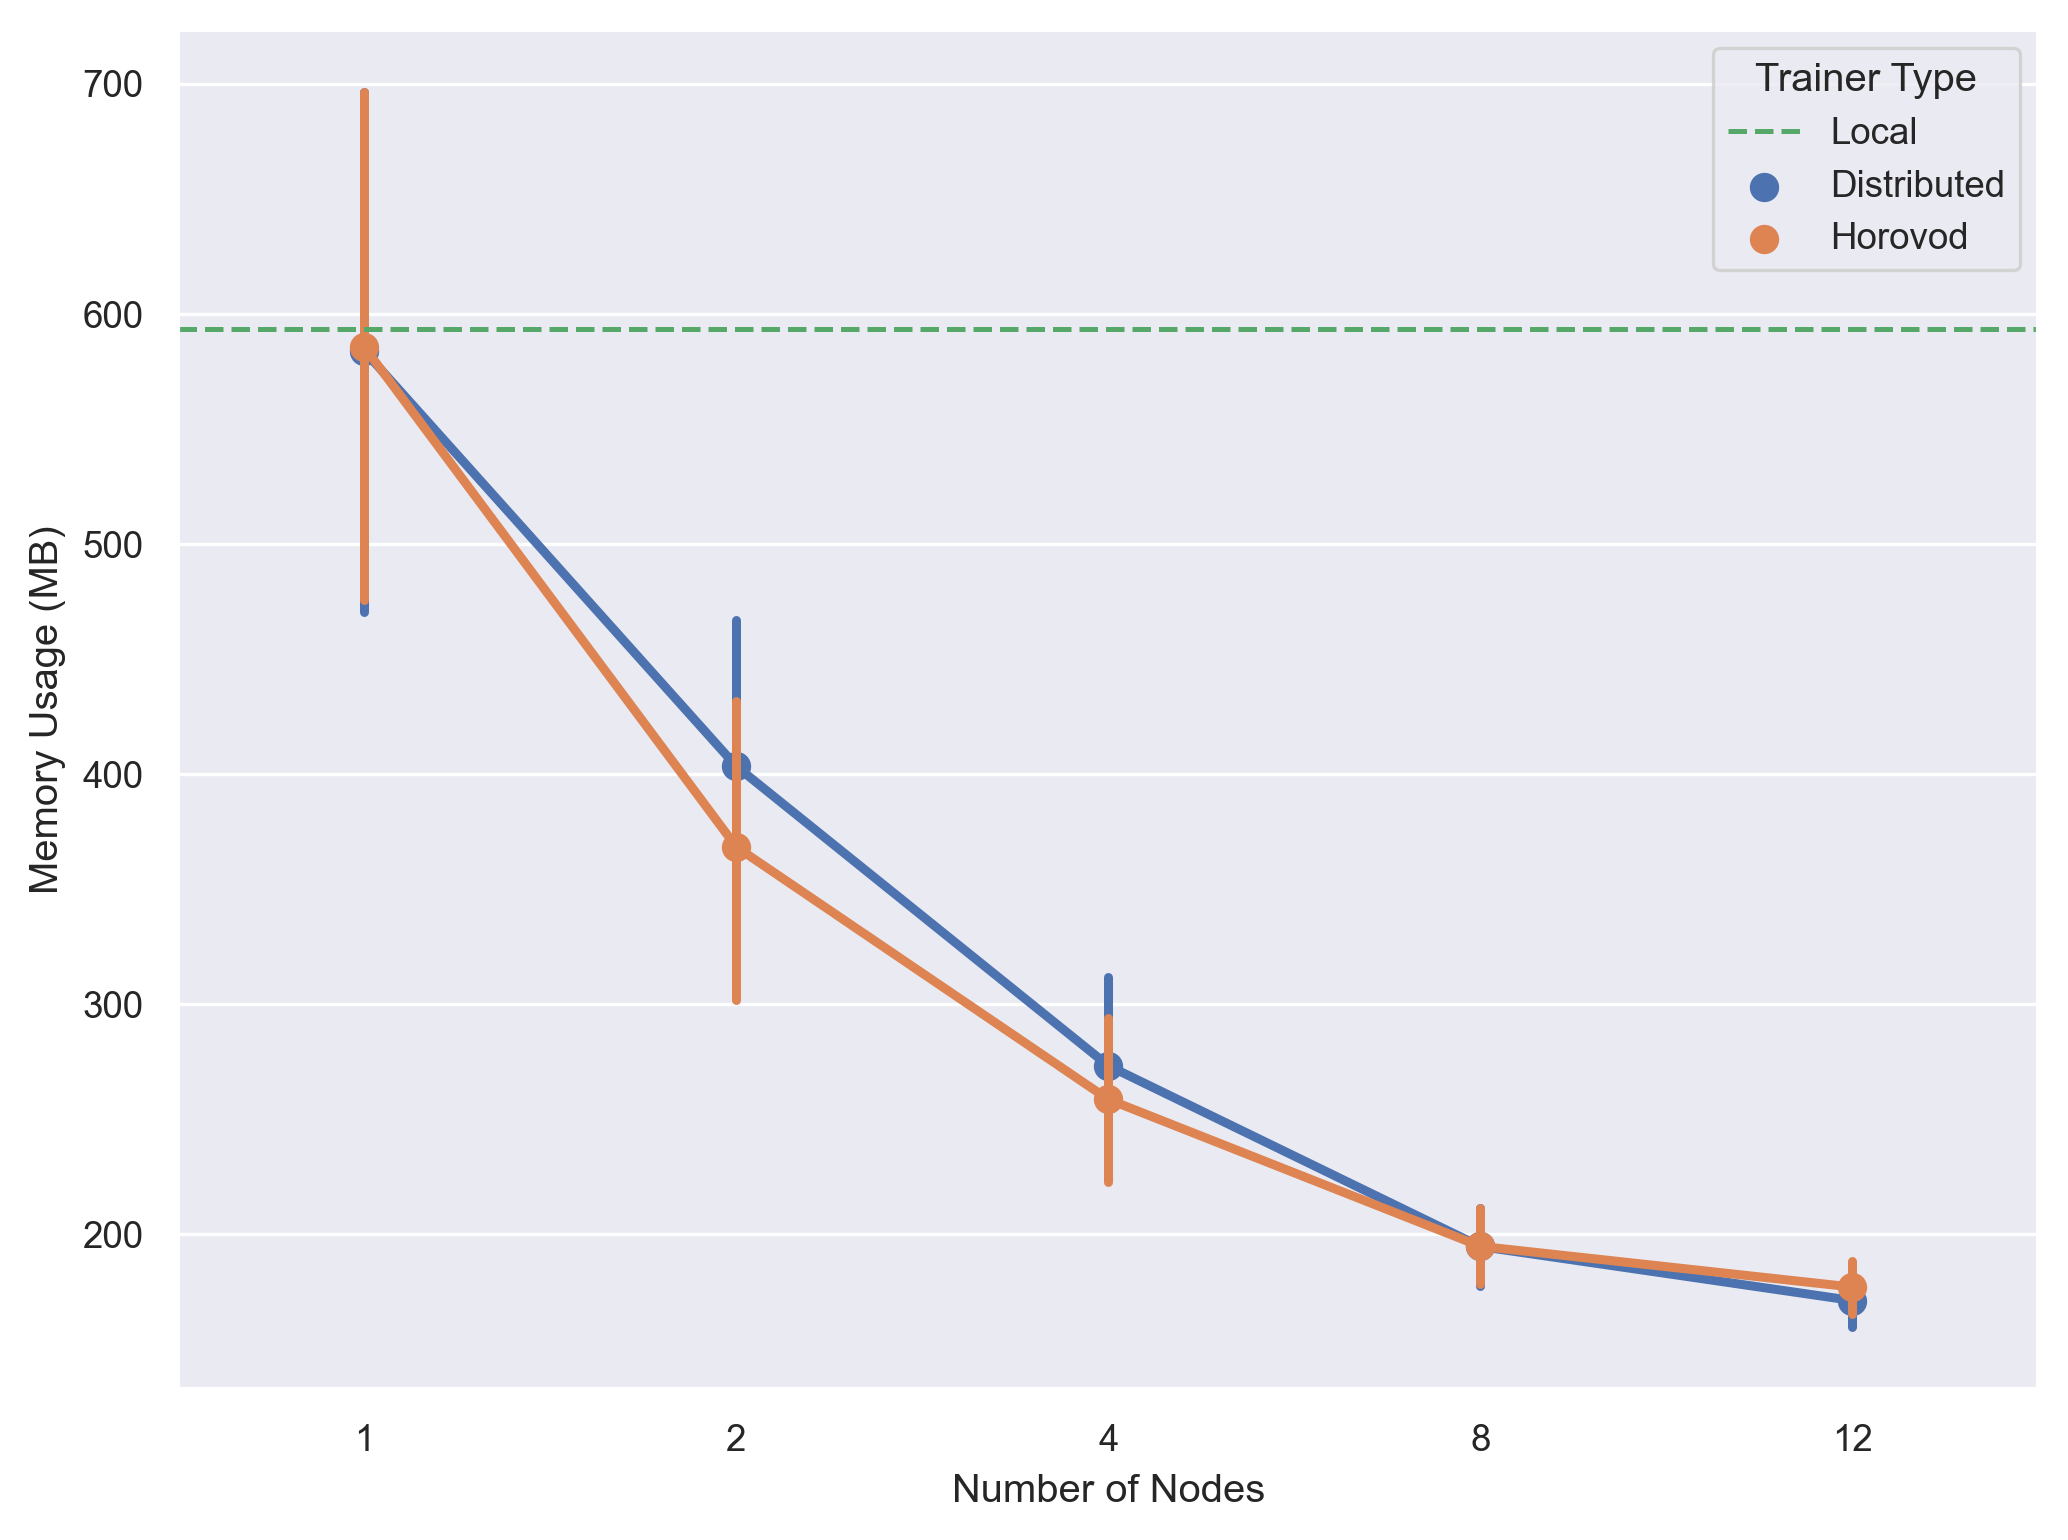

In [15]:
fig = plt.figure(figsize=(8, 6), dpi=300, facecolor="w")
fig.patch.set_alpha(0.0)
ax = sns.pointplot(x="Nodes", y="Memory Usage", hue="Trainer", data=df)
ax.axhline(y=baseline_memory, color=sns.color_palette()[2], linestyle='--', label="Local")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Memory Usage (MB)")
ax.legend().set_title("Trainer Type")
#plt.savefig("memory_usage_overall.png", dpi=300)
tikzplotlib.save(f"memory_usage_overall.tex", figure=fig)

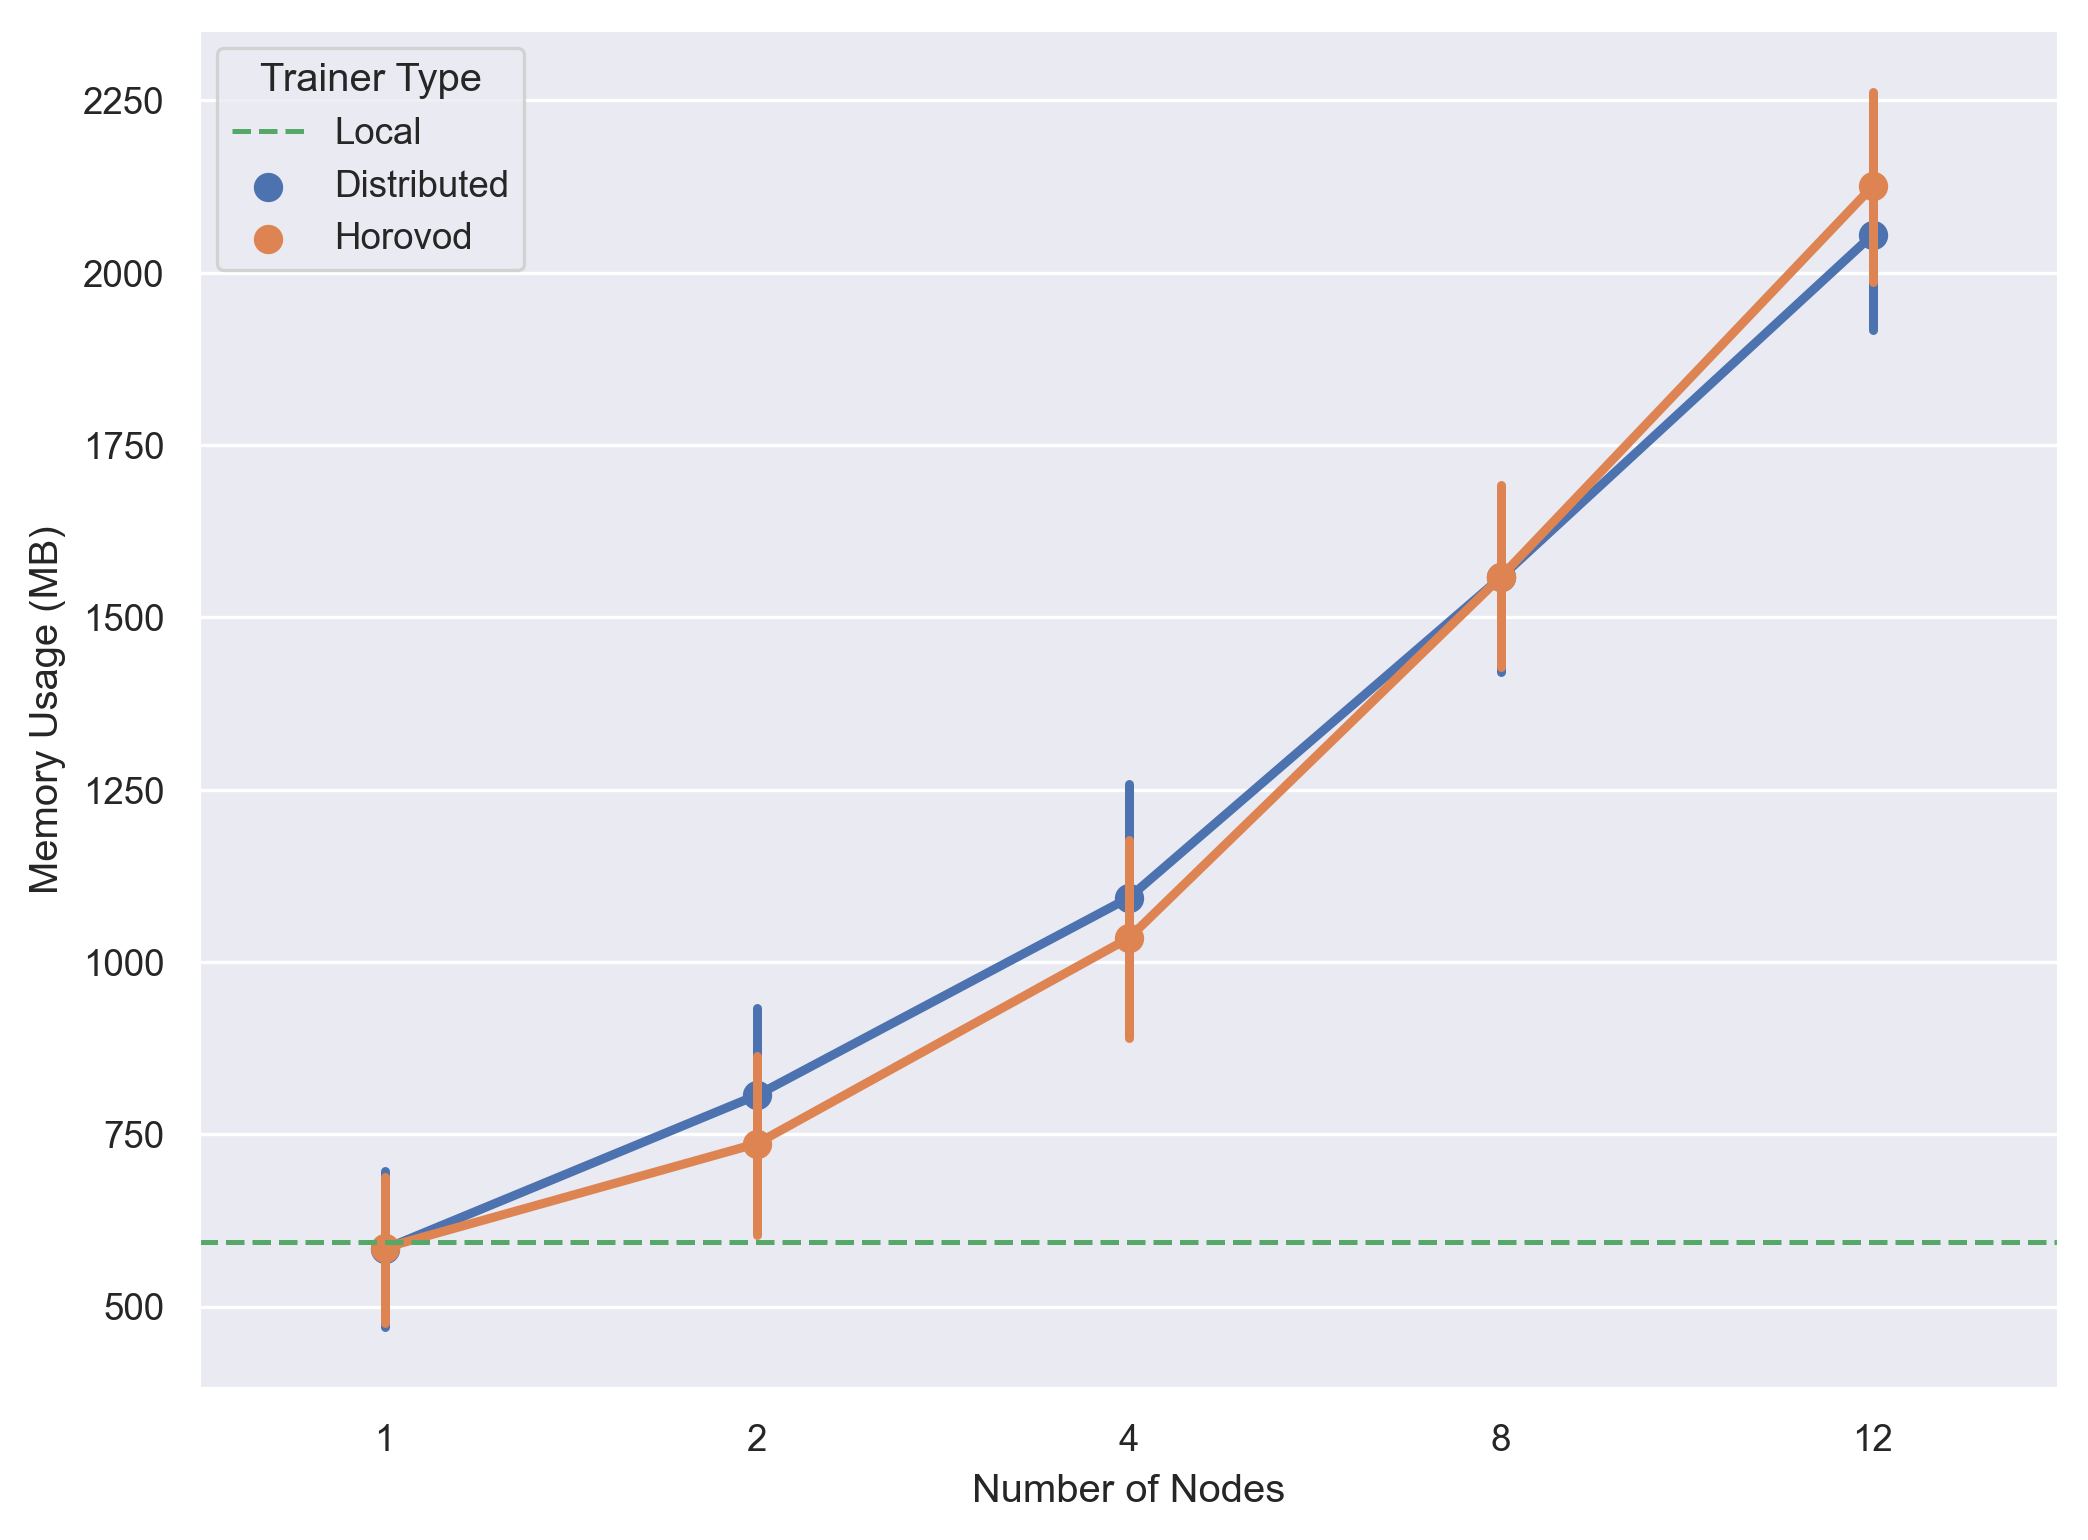

In [16]:
fig = plt.figure(figsize=(8, 6), dpi=300, facecolor="w")
fig.patch.set_alpha(0.0)
ax = sns.pointplot(x="Nodes", y="Memory Usage Overall", hue="Trainer", data=df)
ax.axhline(y=baseline_memory, color=sns.color_palette()[2], linestyle='--', label="Local")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Memory Usage (MB)")
ax.legend().set_title("Trainer Type")
#plt.savefig("memory_usage_overall.png", dpi=300)
tikzplotlib.save(f"memory_usage_overall_cluster.tex", figure=fig)

In [17]:
df_slots = df0.groupby(["Nodes", "Slots"]).mean().reset_index()
df_slots = df_slots[(df_slots["Nodes"] != 8) & (df_slots["Slots"] != 2)]
slice_df = df_slots[df_slots["Slots"] == 4]
est_memeory = slice_df["Memory Usage"] * 4

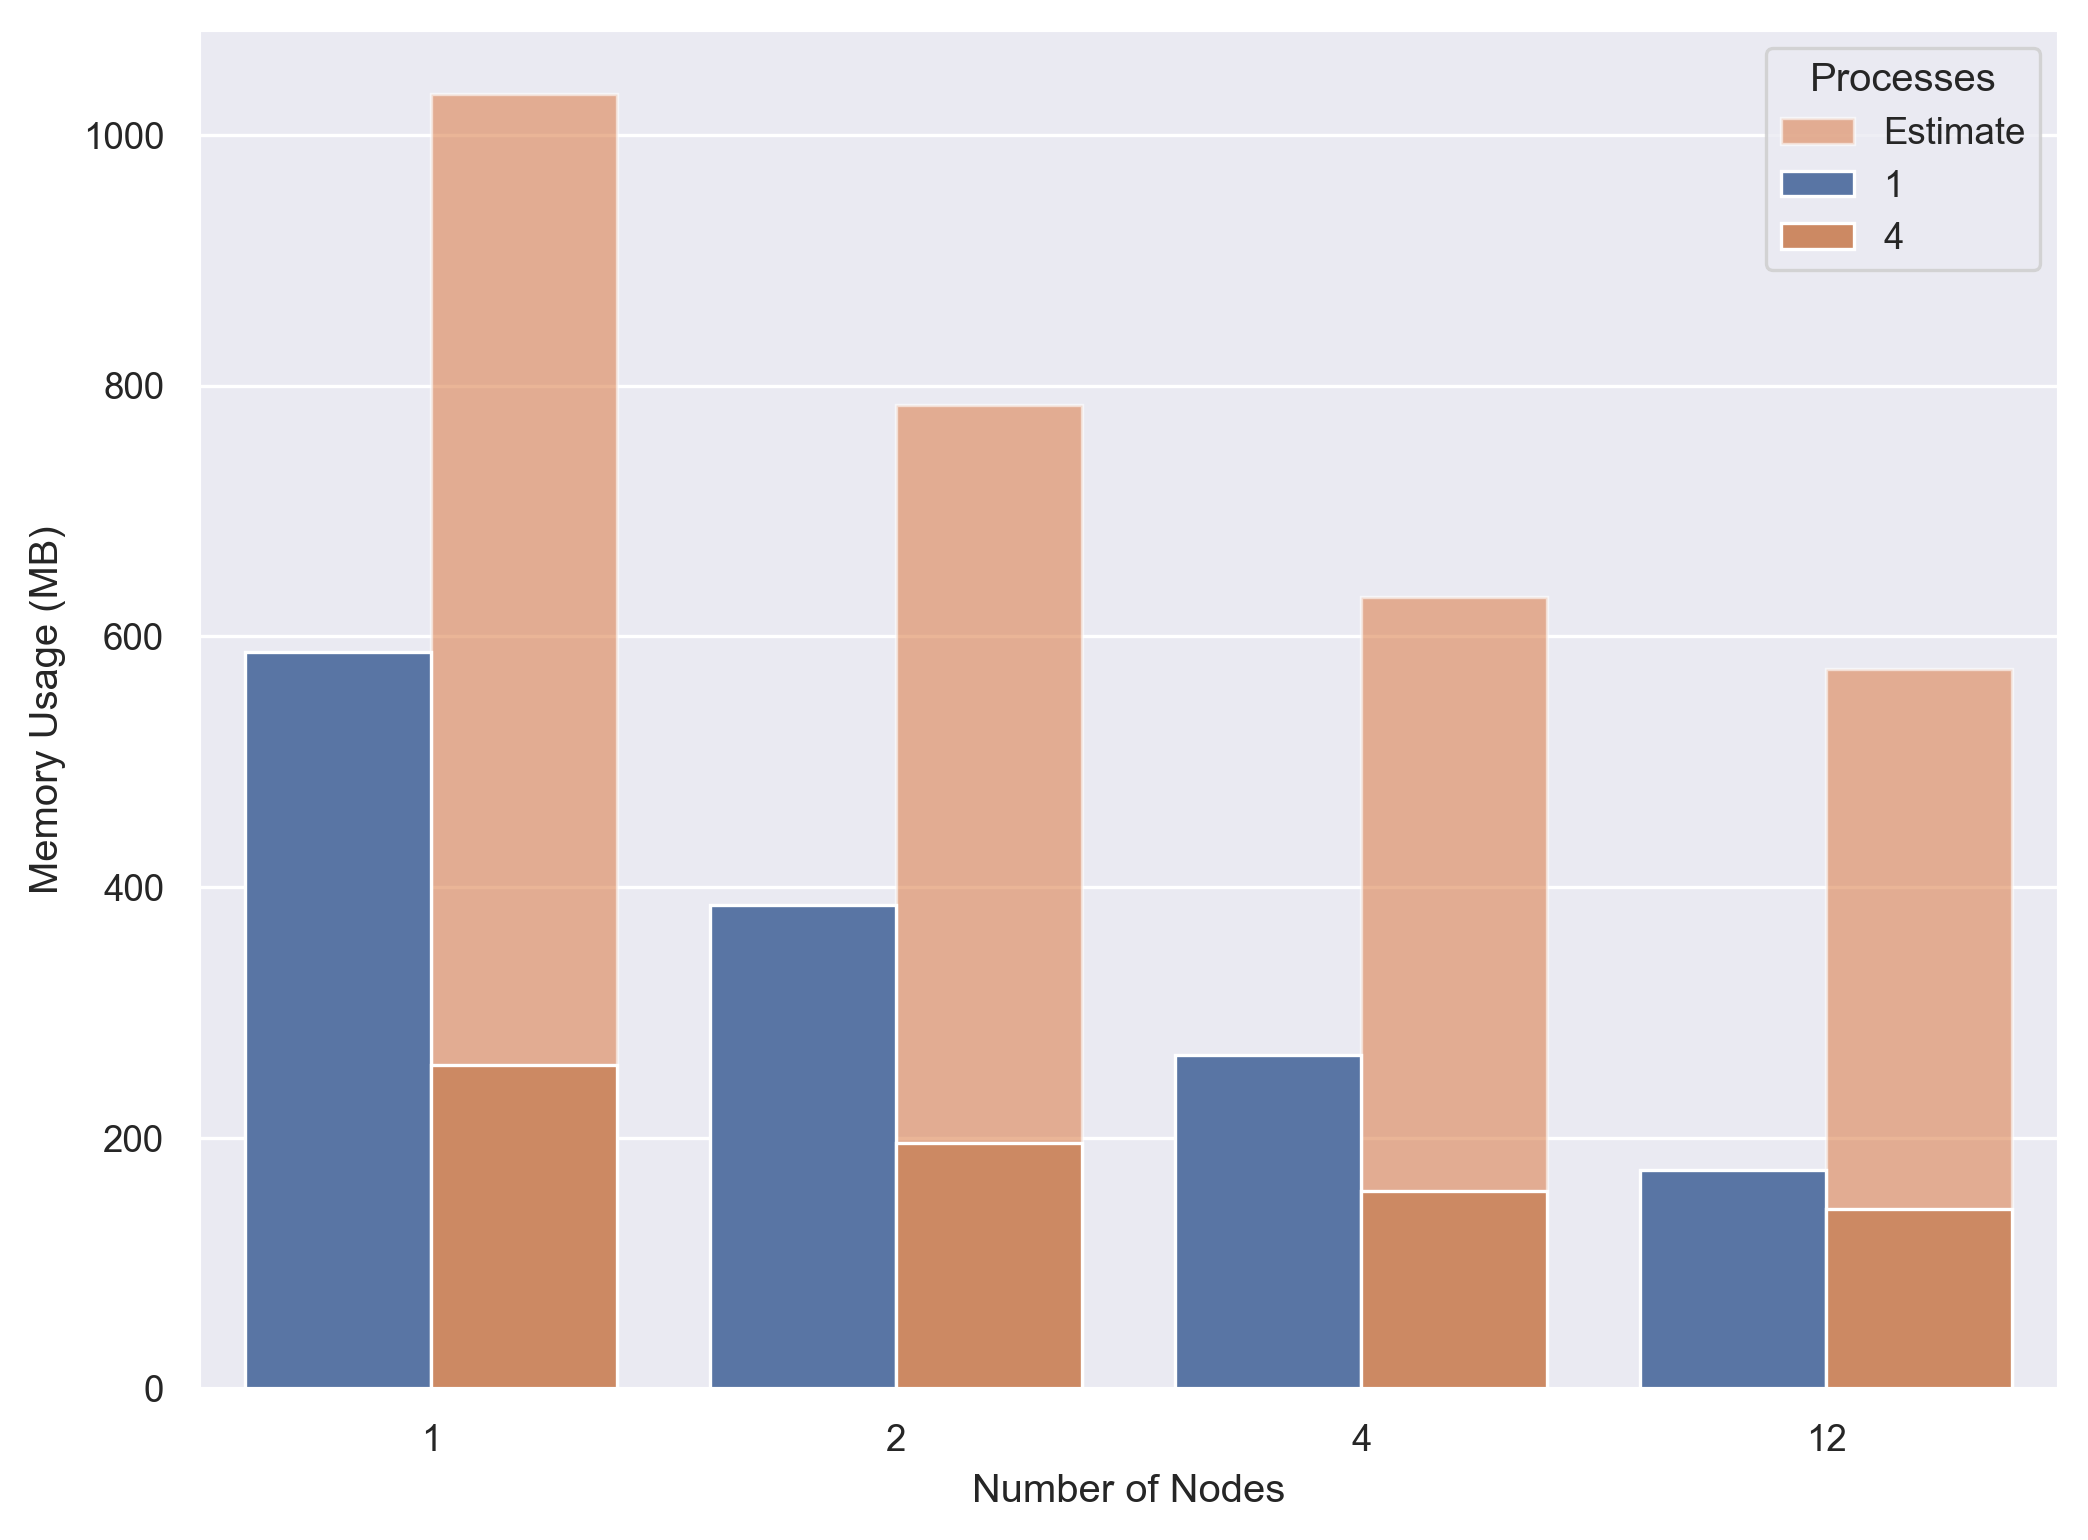

In [18]:
fig = plt.figure(figsize=(8, 6), dpi= 300, facecolor="w")
#fig.patch.set_alpha(0.0)
ax =  fig.add_subplot(111)
ax.bar([0.2, 1.2, 2.2 , 3.2], est_memeory.values, width=0.4, zorder=1, alpha=0.6, color=sns.color_palette()[1], label="Estimate")
ax = sns.barplot(x="Nodes", y="Memory Usage", data=df_slots, hue="Slots", ci=None, zorder=2, ax=ax)    
ax.legend().set_title("Processes")
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Memory Usage (MB)")
#ax.set_title(f"{measurement} for Nodes and Processes")#
#plt.savefig("Memory Usage for Nodes and Processes.png", dpi=300)
tikzplotlib.save(f"memory_usage_slots.tex", figure=fig)